In [1]:
import pandas as pd
import re
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Spark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark import SparkConf

In [3]:
# Spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, DecisionTreeRegressionModel


In [4]:
#Spark SQL functions
from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp, udf, array_distinct, col, when
from pyspark.sql.functions import regexp_replace, year, month, dayofmonth, hour, format_string
from pyspark.sql.functions import monotonically_increasing_id

In [5]:
# Spark Datatypes
from pyspark.sql.types import StringType, TimestampType, DateType, IntegerType
from pyspark.sql.types import DoubleType, StructType, FloatType, StructField

In [6]:
# Spark evaluation metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [7]:
#Sentiment Analyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [8]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

In [9]:
spark_conf = SparkConf().setMaster("local[*]").setAppName("Tweets_Hadoop")

spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()

sc = spark.sparkContext

sc.setLogLevel('ERROR')

24/01/07 16:58:01 WARN Utils: Your hostname, BDS-2023 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/07 16:58:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/07 16:58:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Models in Spark 

In [10]:
df_salvo = spark.read.parquet("hdfs://localhost:9000/CA4/sentiment")

In [11]:
#getting sentiment
tweets_df = df_salvo.withColumn('sentiment',when(col("score") > 0, '1').otherwise('0'))

In [12]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

tweets_hour = tweets_df.groupBy(year("Date/Time").alias("year"), 
                              month("Date/Time").alias("month"),
                              dayofmonth("Date/Time").alias("day"),
                              hour("Date/Time").alias("hour"),
                              "sentiment") \
                        .agg(mean(col("score")).alias("hourly_score"), count(col("score")).alias("hourly_count")) \
                        .orderBy(["year", "month", "day", "hour"])

In [13]:
tweets_hour = tweets_hour.withColumn("datetime", to_timestamp(concat_ws("-", col("year"), col("month"), col("day"), col("hour")), "yyyy-MM-dd-HH"))

In [14]:
tweets_hour.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- hourly_score: double (nullable = true)
 |-- hourly_count: long (nullable = false)
 |-- datetime: timestamp (nullable = true)



In [15]:
tweets_hour.show(10)

+----+-----+---+----+---------+--------------------+------------+-------------------+
|year|month|day|hour|sentiment|        hourly_score|hourly_count|           datetime|
+----+-----+---+----+---------+--------------------+------------+-------------------+
|2009|    4|  7|   5|        0|-0.40446523275664625|          17|2009-04-07 05:00:00|
|2009|    4|  7|   5|        1|   0.647632026921201|          64|2009-04-07 05:00:00|
|2009|    4|  7|   6|        0|-0.43247338705696164|          20|2009-04-07 06:00:00|
|2009|    4|  7|   6|        1|  0.6010633023226333|          85|2009-04-07 06:00:00|
|2009|    4|  7|   7|        1|   0.604386412268001|          74|2009-04-07 07:00:00|
|2009|    4|  7|   7|        0| -0.3747279641063263|          15|2009-04-07 07:00:00|
|2009|    4|  7|   8|        1|  0.6137161426389447|          65|2009-04-07 08:00:00|
|2009|    4|  7|   8|        0|-0.35458866360464264|          21|2009-04-07 08:00:00|
|2009|    4|  7|   9|        1|  0.6003446724369295|  

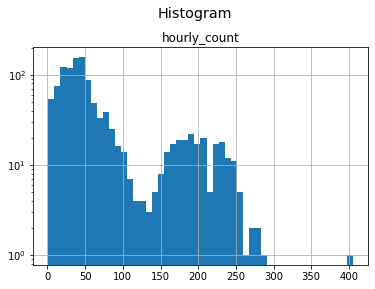

In [16]:
plot_df = tweets_hour.select('hourly_count').toPandas()

plot_df.hist(bins = 50)
plt.yscale('log')
plt.suptitle('Histogram',x=0.5, y=1.02, fontsize='x-large');

# Transformation

In [17]:
def convert_type(df,to_string=[], to_integer=[], to_double = []):
    col_names = df.columns
    
    if len(to_string) > 0:
        for col in to_string:
            df = df.withColumn(col,df[col].cast(StringType()))
    
    if len(to_integer) > 0:
        for col in to_integer:
            df = df.withColumn(col,df[col].cast(IntegerType()))
            
    if len(to_double) > 0:
        for col in to_double:
            df = df.withColumn(col,df[col].cast(DoubleType()))
            
    return df

In [18]:
def compute_metrics_reg(predictions, model_name, labelcol = 'target'):
    
    rmse_obj = RegressionEvaluator(metricName = 'rmse', predictionCol = 'prediction', labelCol = labelcol)
    
    rsquared_obj = RegressionEvaluator(metricName = 'r2', predictionCol = 'prediction', labelCol = labelcol)
    
    print(model_name, 'Metrics:\nRMSE Score:',\
          str(rmse_obj.evaluate(predictions))+ '\nR-Squared Value:',\
          str(rsquared_obj.evaluate(predictions)))

# AutoARIMA

In [19]:
df_hour = tweets_hour.select('sentiment', 'datetime', 'hourly_count') \
                        .withColumnRenamed('sentiment', 'unique_id') \
                        .withColumnRenamed('datetime', 'ds') \
                        .withColumnRenamed('hourly_count', 'y')
df_hour.printSchema()

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format



hour_test = df_hour.withColumn("month", date_format("ds", "yyyy-MM-dd"))


train_ratio = 0.5  
test_ratio = 1.0 - train_ratio


def split_data_by_month(df, train_ratio, test_ratio, seed=42):
    train_df, test_df = df.randomSplit([train_ratio, test_ratio], seed=seed)
    return train_df, test_df


train_df, test_df = split_data_by_month(df_hour, train_ratio, test_ratio)


print("Training:", train_df.count(), "-> {:.2f}%".format((train_df.count() / df_hour.count()) * 100))
print("Testing:", test_df.count(), "-> {:.2f}%".format((test_df.count() / df_hour.count()) * 100))

# Caching the dataframe
train_df = train_df.drop('month')
test_df = test_df.drop('month')


# Caching the dataframe
train_df.cache()
test_df.cache()


# Schema
train_df.printSchema()
test_df.printSchema()

Training: 607 -> 51.57%


Testing: 570 -> 48.43%
root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



## Training and Testing

## Classification Models

In [21]:
tweets_hour_cts_reg = tweets_hour.drop('hourly_score', 'datetime').withColumnRenamed('hourly_count', 'target')
tweets_hour_cts_reg.printSchema()

hour_cts_reg_str = ['year', 'month', 'day', 'hour', 'sentiment']
hour_cts_reg_int = ['target']

tweets_hour_cts_reg = convert_type(df = tweets_hour_cts_reg,
                                  to_string = hour_cts_reg_str, 
                                  to_integer = hour_cts_reg_int)
tweets_hour_cts_reg.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: long (nullable = false)

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)



## Pipeline

In [22]:
#Stage 1 
#String Indexer
inputCols = hour_cts_reg_str
outputCols = [f'{x}_str_dex' for x in hour_cts_reg_str]

hour_cts_reg_stage_1 = StringIndexer(inputCols=inputCols, 
                                     outputCols=outputCols, 
                                     handleInvalid='keep')

#Stage 2
#One Hot Encoder
inputCols_OHE = [x for x in outputCols] 
outputCols_OHE = [f'{x}_ohe' for x in inputCols]

hour_cts_reg_stage_2 = OneHotEncoder(inputCols=inputCols_OHE, 
                                     outputCols=outputCols_OHE)

#Stage 3
#Assembler
inputCols_reg = hour_cts_reg_int
inputCols_reg.extend(outputCols_OHE)

hour_cts_reg_stage_3 = VectorAssembler(inputCols=inputCols_reg,
                                        outputCol="features")

## Stage 2: Building Models
## Stage 2.1: Decision Tree classification

In [23]:
hour_cts_reg_dt_stage_4 = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'target',impurity='variance',\
                                       maxDepth=5, maxBins=40) 

In [24]:
hour_cts_reg_dt_pipeline = Pipeline(stages = [hour_cts_reg_stage_1,
                                    hour_cts_reg_stage_2,
                                    hour_cts_reg_stage_3,
                                    hour_cts_reg_dt_stage_4])

## Stage 2.2: GB Tree classification

In [25]:
hour_cts_reg_gbt_stage_4 = GBTRegressor(featuresCol="features",labelCol = 'target', maxIter=5)

In [26]:
hour_cts_reg_gbt_pipeline = Pipeline(stages = [hour_cts_reg_stage_1,
                                    hour_cts_reg_stage_2,
                                    hour_cts_reg_stage_3,
                                    hour_cts_reg_gbt_stage_4])

In [27]:
from pyspark.sql import SparkSession


hour_cts_reg_train_df, hour_cts_reg_test_df = tweets_hour_cts_reg.randomSplit([0.5, 0.5], seed=42)

# Print counts and percentages
print("Training:", hour_cts_reg_train_df.count(),
      f"-> {(hour_cts_reg_train_df.count() / tweets_hour_cts_reg.count() * 100):.2f}%")

print("Testing:", hour_cts_reg_test_df.count(),
      f"-> {(hour_cts_reg_test_df.count() / tweets_hour_cts_reg.count() * 100):.2f}%\n")

# Caching the DataFrame
hour_cts_reg_train_df.cache()
hour_cts_reg_test_df.cache()

# Print schema
hour_cts_reg_train_df.printSchema()
hour_cts_reg_test_df.printSchema()


Training: 607 -> 51.57%


Testing: 570 -> 48.43%

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- target: integer (nullable = false)



In [28]:
# pipeline
hour_cts_reg_dt_model = hour_cts_reg_dt_pipeline.fit(hour_cts_reg_train_df)

# make predictions
hour_cts_reg_dt_Predictions = hour_cts_reg_dt_model.transform(hour_cts_reg_test_df)

In [29]:
hour_cts_reg_dt_Predictions.select('year', 'month', 'day', 'hour', 'target', 'prediction').show(5)

+----+-----+---+----+------+-----------------+
|year|month|day|hour|target|       prediction|
+----+-----+---+----+------+-----------------+
|2009|    4|  7|   5|    17|19.48148148148148|
|2009|    4|  7|   5|    64|             67.0|
|2009|    4|  7|   6|    20|19.48148148148148|
|2009|    4|  7|   7|    15|             14.4|
|2009|    4|  7|   7|    74|           74.375|
+----+-----+---+----+------+-----------------+
only showing top 5 rows



In [30]:
compute_metrics_reg(hour_cts_reg_dt_Predictions,'Decision Tree Model', labelcol = 'target')

Decision Tree Model Metrics:
RMSE Score: 5.221657973972694
R-Squared Value: 0.9939377004722054


In [31]:
# pipeline
hour_cts_reg_gbt_model = hour_cts_reg_gbt_pipeline.fit(hour_cts_reg_train_df)

# make predictions
hour_cts_reg_gbt_Predictions = hour_cts_reg_gbt_model.transform(hour_cts_reg_test_df)

In [32]:
hour_cts_reg_gbt_Predictions.select('year', 'month', 'day', 'hour', 'target', 'prediction').show(5)

+----+-----+---+----+------+------------------+
|year|month|day|hour|target|        prediction|
+----+-----+---+----+------+------------------+
|2009|    4|  7|   5|    17|18.976881134188453|
|2009|    4|  7|   5|    64| 64.00159069025996|
|2009|    4|  7|   6|    20|19.896439705788005|
|2009|    4|  7|   7|    15|18.976881134188453|
|2009|    4|  7|   7|    74| 73.85607985434666|
+----+-----+---+----+------+------------------+
only showing top 5 rows



In [33]:
compute_metrics_reg(hour_cts_reg_gbt_Predictions, 'GB Tree Model', labelcol = 'target')

GB Tree Model Metrics:
RMSE Score: 5.559843274226615
R-Squared Value: 0.9931270110411099


# Creating Models in Pandas


In [34]:
# Caminho para salvar os dados no Hadoop
hadoop_path = "hdfs://localhost:9000/CA4/forecast/dataframe/"



In [35]:
#Reading all parquets file in the folder tweets on Hadoop
tweets_hour = spark.read.parquet("hdfs://localhost:9000//CA4/forecast/dataframe/*.parquet")

In [36]:
#converting to pandas
tweets_hour_pd = tweets_hour.withColumn("datetime", date_format("datetime", "yyyy-MM-dd HH:mm:ss")).toPandas()
tweets_hour_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          1177 non-null   int32  
 1   month         1177 non-null   int32  
 2   day           1177 non-null   int32  
 3   hour          1177 non-null   int32  
 4   sentiment     1177 non-null   object 
 5   hourly_score  1177 non-null   float64
 6   hourly_count  1177 non-null   int64  
 7   datetime      1177 non-null   object 
dtypes: float64(1), int32(4), int64(1), object(2)
memory usage: 55.3+ KB


In [37]:
print(len(tweets_hour_pd))
tweets_hour_pd[tweets_hour_pd.datetime == '2009-04-07 01:00:00']

1177


,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime


In [38]:
tweets_hour_pd = tweets_hour_pd.drop_duplicates(subset=['datetime','sentiment'])
print(len(tweets_hour_pd))
tweets_hour_pd[tweets_hour_pd.datetime == '2009-04-07 01:00:00']

1177


,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime


In [39]:
# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler

# models
#from darts.models import NaiveSeasonal, StatsForecastAutoARIMA, ExponentialSmoothing, Prophet #local
#from darts.models import LightGBMModel, RNNModel, NBEATSModel, TFTModel #global

# likelihood
#from darts.utils.likelihood_models import GaussianLikelihood

# evaluation
from darts.metrics import mape, coefficient_of_variation, mae 

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [40]:
# make copy of df
dataset_scaled_EDA = tweets_hour_pd.copy()

# min max value calculation
dataset_scaled_EDA['min_hour'] = dataset_scaled_EDA.groupby(['hour','sentiment'])[['hourly_count']] \
                                    .transform(lambda x: x.min())
dataset_scaled_EDA['max_hour'] = dataset_scaled_EDA.groupby(['hour','sentiment'])[['hourly_count']] \
                                    .transform(lambda x: x.max())

# scale
dataset_scaled_EDA['hour_scaled'] = (dataset_scaled_EDA['hourly_count'] - dataset_scaled_EDA['min_hour'])/(dataset_scaled_EDA['max_hour'] - dataset_scaled_EDA['min_hour'])

# add info about year, week of year and day of week
dataset_scaled_EDA['datetime'] = pd.to_datetime(dataset_scaled_EDA['datetime'])
dataset_scaled_EDA['day_of_week'] = [d.strftime('%A') for d in dataset_scaled_EDA['datetime']]
dataset_scaled_EDA['day_of_week'] = pd.Categorical(dataset_scaled_EDA['day_of_week'], 
  categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
  ordered=True)

dataset_scaled_EDA.head(10)


,year,month,day,hour,sentiment,hourly_score,hourly_count,datetime,min_hour,max_hour,hour_scaled,day_of_week
0,2009,4,7,5,1,0.647632,64,2009-04-07 05:00:00,8,278,0.207407,Tuesday
1,2009,4,7,5,0,-0.404465,17,2009-04-07 05:00:00,3,54,0.274510,Tuesday
2,2009,4,7,6,0,-0.432473,20,2009-04-07 06:00:00,10,59,0.204082,Tuesday
3,2009,4,7,6,1,0.601063,85,2009-04-07 06:00:00,44,249,0.200000,Tuesday
4,2009,4,7,7,1,0.604386,74,2009-04-07 07:00:00,34,230,0.204082,Tuesday
5,2009,4,7,7,0,-0.374728,15,2009-04-07 07:00:00,11,63,0.076923,Tuesday
6,2009,4,7,8,0,-0.354589,21,2009-04-07 08:00:00,14,47,0.212121,Tuesday
7,2009,4,7,8,1,0.613716,65,2009-04-07 08:00:00,26,200,0.224138,Tuesday
8,2009,4,7,9,1,0.600345,72,2009-04-07 09:00:00,24,193,0.284024,Tuesday
9,2009,4,7,9,0,-0.401946,6,2009-04-07 09:00:00,6,50,0.000000,Tuesday


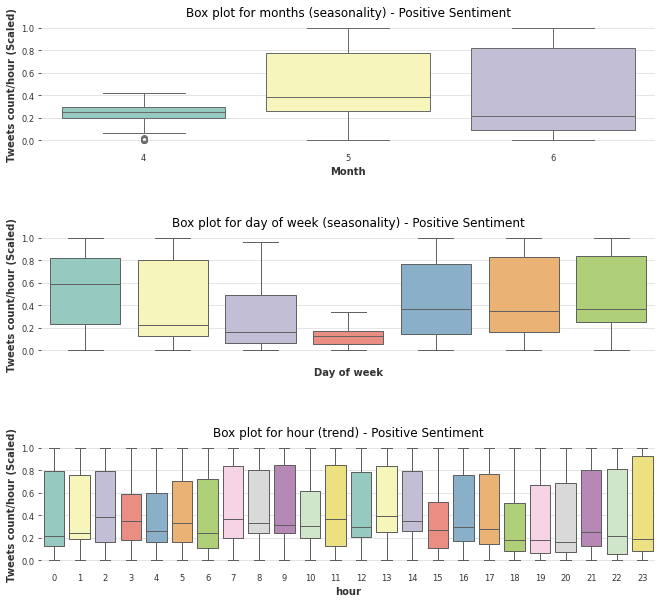

In [41]:
#Positive


s_id = '1'
df = dataset_scaled_EDA[dataset_scaled_EDA.sentiment == s_id]
sentiment = 'Negative' if s_id == '0' else 'Positive'

palette = "Set3"

fig, ax = plt.subplots(3, 1, figsize=(11, 10))
sns.boxplot(x='month', y='hour_scaled', data=df, ax=ax[0], palette=palette) \
    .set(xlabel='Month', ylabel='Tweets count/hour (Scaled)')
ax[0].set_title(f'Box plot for months (seasonality) - {sentiment} Sentiment')

sns.boxplot(x='day_of_week', y='hour_scaled', data=df, ax=ax[1], palette=palette) \
    .set(xlabel='Day of week', ylabel='Tweets count/hour (Scaled)')
ax[1].set_title(f'Box plot for day of week (seasonality) - {sentiment} Sentiment')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

sns.boxplot(x='hour', y='hour_scaled', data=df, ax=ax[2], palette=palette) \
    .set(xlabel='hour', ylabel='Tweets count/hour (Scaled)')
ax[2].set_title(f'Box plot for hour (trend) - {sentiment} Sentiment')

plt.subplots_adjust(hspace=0.7) 
plt.show()


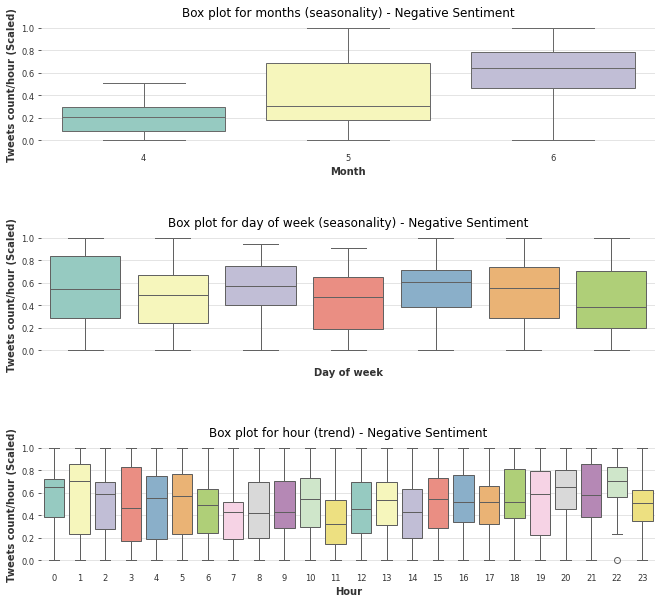

In [42]:
s_id = '0'
df = dataset_scaled_EDA[dataset_scaled_EDA.sentiment == s_id]
sentiment = 'Negative' if s_id == '0' else 'Positive'

palette = "Set3"

fig, ax = plt.subplots(3, 1, figsize=(11, 10))
sns.boxplot(x='month', y='hour_scaled', data=df, ax=ax[0], palette=palette) \
    .set(xlabel='Month', ylabel='Tweets count/hour (Scaled)')
ax[0].set_title(f'Box plot for months (seasonality) - {sentiment} Sentiment')

sns.boxplot(x='day_of_week', y='hour_scaled', data=df, ax=ax[1], palette=palette) \
    .set(xlabel='Day of week', ylabel='Tweets count/hour (Scaled)')
ax[1].set_title(f'Box plot for day of week (seasonality) - {sentiment} Sentiment')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

sns.boxplot(x='hour', y='hour_scaled', data=df, ax=ax[2], palette=palette) \
    .set(xlabel='Hour', ylabel='Tweets count/hour (Scaled)')
ax[2].set_title(f'Box plot for hour (trend) - {sentiment} Sentiment')

plt.subplots_adjust(hspace=0.7) 
plt.show()


In [44]:
from sklearn.model_selection import train_test_split

def set_df_sent(df_send, sent=False, target_col='hourly_count', rename_target_col='target', new_index=False,
                split_col='datetime', split_date='2009-10-01', freq_timestamp='H', x_col=[]):

    df = df_send.copy()
    
    n_row = len(df)

    if not sent == False:
        sent_desc = 'Positive' if sent == '1' else 'Negative'
        print(f'Dataframe Sentiment: {sent_desc}')

        # Remove Sentiment:
        df = df[df.sentiment == sent]
        n_row = len(df)

    print(f'Total Number of rows: {n_row}')
    cols = x_col

    if not new_index == False:
        # Apply Time as index
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        df = df.set_index('datetime')

        # Verifying if there are missing time (hour)
        df = df.asfreq(freq_timestamp)
        print(f"NA's rows Number: {np.abs(n_row - len(df))}")
        df = df.fillna(0)

    df = df.rename(columns={target_col: rename_target_col})
    cols.append(rename_target_col)
    
    if new_index == False:
        cols.append(split_col)

    df = df[cols]

    # Splitting dataframes into train-test
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

    print(f"Train dates : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)} -> {len(df_train)/len(df):.2%})")
    print(f"Test dates  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)} -> {len(df_test)/len(df):.2%})")

    fig, ax = plt.subplots(figsize=(11, 4))
    df_train[rename_target_col].plot(ax=ax, label='train', color='blue')
    df_test[rename_target_col].plot(ax=ax, label='test', color='black')
    ax.legend();
    ax.set_title(f"Train-Test dataframes {sent_desc} Sentiment")

    return df, df_train, df_test


Dataframe Sentiment: Positive
Total Number of rows: 590
NA's rows Number: 1319
Train dates : 2009-04-07 05:00:00 --- 2009-06-25 17:00:00  (n=954 -> 49.97%)
Test dates  : 2009-04-07 08:00:00 --- 2009-06-25 16:00:00  (n=955 -> 50.03%)


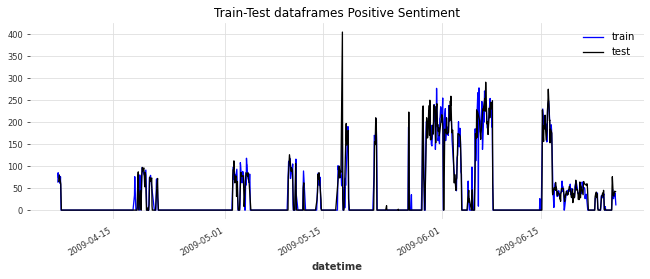

In [45]:
tweets_hour_pos, tweets_hour_pos_train, tweets_hour_pos_test = set_df_sent(tweets_hour_pd, rename_target_col = 'target',
                                                                          sent = '1', new_index="datetime")

Dataframe Sentiment: Negative
Total Number of rows: 587
NA's rows Number: 1322
Train dates : 2009-04-07 05:00:00 --- 2009-06-25 17:00:00  (n=954 -> 49.97%)
Test dates  : 2009-04-07 08:00:00 --- 2009-06-25 16:00:00  (n=955 -> 50.03%)


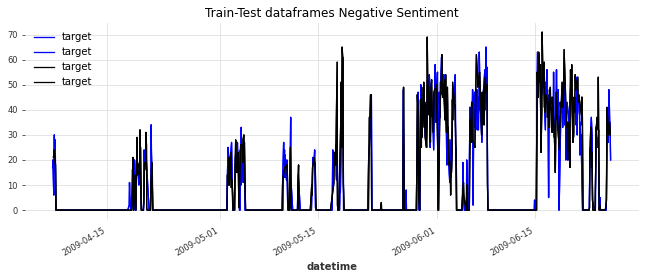

In [46]:
tweets_hour_neg, tweets_hour_neg_train, tweets_hour_neg_test = set_df_sent(tweets_hour_pd, 
                                                                           rename_target_col='target',
                                                                           sent='0',
                                                                           new_index="datetime")


In [60]:

from statsmodels.tsa.stattools import kpss



# Função para realizar o KPSS test
def kpss_test(series):
    result = kpss(series, regression='c', nlags='auto')
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[3])
    print('Is the time series stationary?', 'Yes (stationary)' if result[1] <= 0.05 else 'No (non-stationary)')


kpss_test(serie)


KPSS Statistic: 1.1984768905432346
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary? Yes (stationary)


In [62]:
from statsmodels.tsa.stattools import kpss

# ...

# Função para realizar o KPSS test com número específico de lags
def kpss_test(series, num_lags=20):
    result = kpss(series, regression='c', nlags=num_lags)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[3])
    print('Is the time series stationary?', 'Yes (stationary)' if result[1] <= 0.05 else 'No (non-stationary)')

# ...

# Chamar a função kpss_test com um número específico de lags
kpss_test(serie, num_lags=20)


KPSS Statistic: 1.468714450858869
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary? Yes (stationary)


ADF Statistic: -4.313818535763958
p-value: 0.00042036303474132916
Critical Values: {'1%': -3.4338294057711836, '5%': -2.863076961232155, '10%': -2.567588221339588}


KPSS Statistic: 1.468714450858869
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary? Yes (stationary)

 	 Graphics 



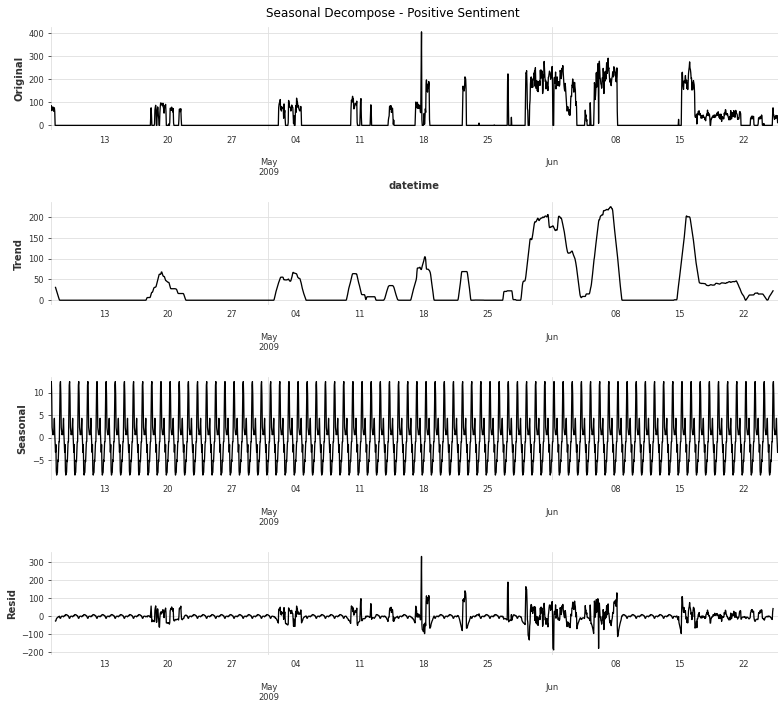

In [63]:
serie = tweets_hour_pos['target']
index = pd.date_range(start=tweets_hour_pos.index.min(), end=tweets_hour_pos.index.max(), freq='H')
serie = pd.Series(serie.values, index=index)

adf_test(serie)
print('\n')
kpss_test(serie)
    
print('\n', '\t Graphics', '\n')
    
result_decompose = seasonal_decompose(serie, model='additive')

# Plotar as componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 10))
tweets_hour_pos['target'].plot(ax=ax1)
ax1.set_ylabel('Original')
result_decompose.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result_decompose.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result_decompose.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

fig.suptitle('Seasonal Decompose - Positive Sentiment')
plt.tight_layout()
plt.show()

ADF Statistic: -3.8366910200502833
p-value: 0.002553454006733663
Critical Values: {'1%': -3.4338294057711836, '5%': -2.863076961232155, '10%': -2.567588221339588}



 	 Graphics 



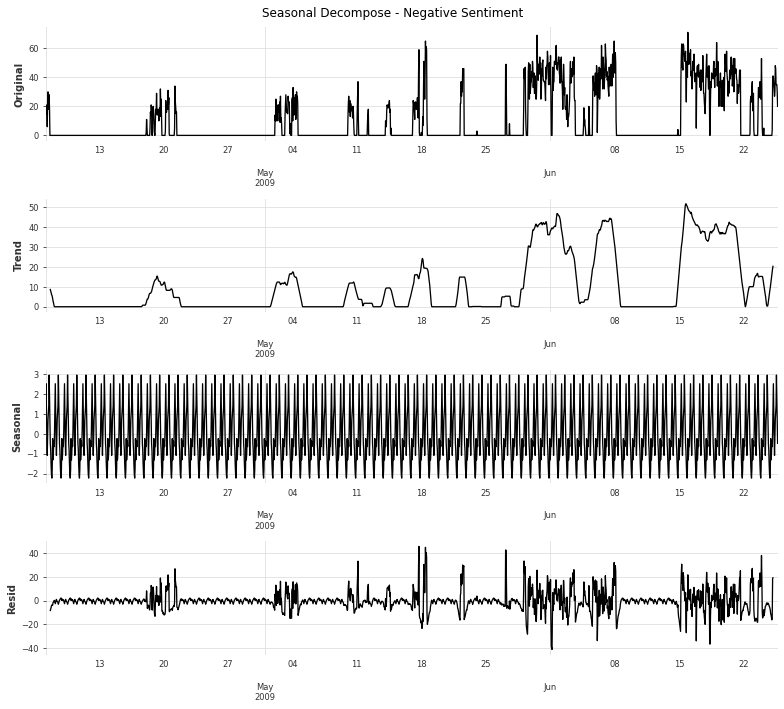

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Supondo que 'tweets_hour_neg' seja a série temporal
serie = tweets_hour_neg['target'].mean(axis=1)  # Média das colunas
index = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='H')
serie = pd.Series(serie.values, index=index)

# Função para realizar o teste ADF
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Realizar o teste ADF
adf_test(serie)
print('\n')

# Plotar a decomposição sazonal
print('\n', '\t Graphics', '\n')
result_decompose = seasonal_decompose(serie, model='additive')

# Plotar as componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 10))
serie.plot(ax=ax1)
ax1.set_ylabel('Original')
result_decompose.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result_decompose.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result_decompose.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

fig.suptitle('Seasonal Decompose - Negative Sentiment')  # Corrigido para 'Negative Sentiment'
plt.tight_layout()
plt.show()


In [66]:
dataset_ts = tweets_hour_pd.copy()
dataset_ts = TimeSeries.from_group_dataframe(df=dataset_ts,
                                             group_cols= 'sentiment',
                                             time_col='datetime',
                                             value_cols='hourly_count',
                                             freq= 'H',
                                            )

# Training and testing

In [68]:
dataset_ts = tweets_hour_pd.copy()
dataset_ts = TimeSeries.from_group_dataframe(df=dataset_ts,
                                             group_cols= 'sentiment',
                                             time_col='datetime',
                                             value_cols='hourly_count',
                                             freq= 'H',
                                            )

In [69]:
print(type(dataset_ts))


<class 'list'>


In [70]:
import numpy as np
from darts import TimeSeries

# Exemplo de dados unidimensionais
flattened_values = np.array([3818, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Certifique-se de que os dados têm uma dimensão
flattened_values = flattened_values.ravel()

# Crie a série temporal
dataset_ts = TimeSeries.from_values(flattened_values)





In [71]:
print(dataset_ts.time_index[0])  # Verifique o primeiro timestamp
print(dataset_ts.time_index[-1])  # Verifique o último timestamp


0
31


<AxesSubplot:xlabel='time'>

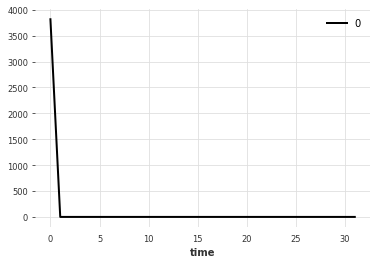

In [72]:
dataset_ts.plot()


In [73]:
import pandas as pd
from tqdm import tqdm
from darts import TimeSeries

# Suponha que dataset_ts seja uma lista de objetos TimeSeries

# Defina a porcentagem de dados a serem usados para treino
train_percentage = 0.8

train_dataset_ts, test_dataset_ts = [], []

for single_ts in tqdm(dataset_ts):
    # Determine o índice para dividir os dados
    split_index = int(len(single_ts) * train_percentage)

    # Divida os dados em conjuntos de treino e teste
    single_train_ts = single_ts[:split_index]
    single_test_ts = single_ts[split_index:]

    train_dataset_ts.append(single_train_ts)
    test_dataset_ts.append(single_test_ts)


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 78.79it/s]


## NaiveSeasonal


In [74]:
def _backtests_local_estimator(_estimator, _ts_set, _split_date, _horizons, _single_forecast=True):
    model = _estimator

    # Verifique se a data de divisão está dentro do intervalo da série temporal
    if _split_date not in _ts_set:
        print(f"Erro: A data de divisão {_split_date} está fora do intervalo da série temporal.")
        return None  # Retorna None para indicar que a previsão não é válida

    try:
        if _single_forecast:
            model.fit(_ts_set.split_before(_split_date)[0])
            backtests_single_ts = model.predict(_horizons)
            return backtests_single_ts
        else:
            backtests_single_ts = model.historical_forecasts(series=_ts_set, 
                                                             start=_split_date - np.timedelta64(_horizons-1, 'D'), 
                                                             verbose=False, 
                                                             overlap_end=False,
                                                             last_points_only=True, 
                                                             forecast_horizon=_horizons,
                                                             retrain=True)
            return backtests_single_ts
    except Exception as e:
        print(f"Erro ao realizar previsão: {e}")
        return None  # Retorna None em caso de erro
    


In [75]:
from darts.models import NaiveSeasonal
from darts.metrics import mape
from darts.metrics import coefficient_of_variation
from darts.metrics import mae

backtests_baseline_model = backtests_multiple_local_estimators(estimator=NaiveSeasonal(K=365))
print(backtests_baseline_model)
darts_kpi(backtests_baseline_model)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_baseline_model[0].plot(label='Forecast', color='green')
plt.show()




NameError: name 'backtests_multiple_local_estimators' is not defined

In [76]:
from module_name import StatsForecastAutoARIMA


backtests_AUTOarima = backtests_multiple_local_estimators(estimator=StatsForecastAutoARIMA())
darts_kpi(backtests_AUTOarima)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_AUTOarima[0].plot(label='Forecast', color='green')
plt.show()

ModuleNotFoundError: No module named 'module_name'

In [77]:
from fbprophet import Prophet

backtests_prophet = backtests_multiple_local_estimators(estimator=Prophet())
darts_kpi(backtests_prophet)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_prophet[0].plot(label='Forecast', color='green')
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

In [78]:
from darts.models import Croston

backtests_croston = backtests_multiple_local_estimators(estimator=Croston())
darts_kpi(backtests_croston)

fig, ax = plt.subplots(figsize=(30, 10))
test_dataset_ts[0].plot(label='True value', color='black')
backtests_croston[0].plot(label='Forecast', color='green')
plt.show()

NameError: name 'backtests_multiple_local_estimators' is not defined

In [79]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [80]:
tweets_hour_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          1177 non-null   int32  
 1   month         1177 non-null   int32  
 2   day           1177 non-null   int32  
 3   hour          1177 non-null   int32  
 4   sentiment     1177 non-null   object 
 5   hourly_score  1177 non-null   float64
 6   hourly_count  1177 non-null   int64  
 7   datetime      1177 non-null   object 
dtypes: float64(1), int32(4), int64(1), object(2)
memory usage: 55.3+ KB


In [81]:
df = tweets_hour_pd.copy()

df = df[['year', 'month', 'day', 'hour', 'sentiment','hourly_count']]

n_row = len(df)
print(f'Total Number of rows: {n_row}')

#verifying if there are na's value   
df = df.dropna()
print(f"NA's rows Number: {np.abs(n_row - len(df))}")

X, y = df[['year', 'month', 'day', 'hour', 'sentiment']].values, df[['hourly_count']].values

Total Number of rows: 1177
NA's rows Number: 0


Total Number of rows: 1177
Train dates : 1 --- 1176  (n=588 -> 49.96%)
Test dates  : 0 --- 1173  (n=589 -> 50.04%)


UnboundLocalError: local variable 'sent_desc' referenced before assignment

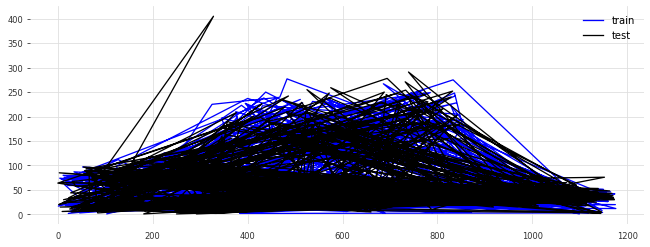

In [82]:
df, df_train, df_test = set_df_sent(tweets_hour_pd, x_col= ['year', 'month', 'day', 'hour', 'sentiment'],
                                    target_col = 'hourly_count', rename_target_col = 'target')

X_train = df_train[['year', 'month', 'day', 'hour', 'sentiment']].values
X_test = df_test[['year', 'month', 'day', 'hour', 'sentiment']].values
y_train = df_train['target']
y_test = df_test['target']

In [83]:
#Splitting dataframes into train-test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 
print(f"Train n={len(X_train)} -> {len(X_train)/len(df):.2%})")
print(f"Test n={len(X_test)} -> {len(X_test)/len(df):.2%})")

Train n=941 -> 79.95%)
Test n=236 -> 20.05%)


In [84]:
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.10,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=5,
)
reg_mod.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [85]:
reg_mod.fit(X_train,y_train)

predictions = reg_mod.predict(X_test)

In [86]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

RMSE: 28.578421
R_Squared Score : 0.871214


In [87]:
def df_future(df_trained, day_future, model):
    
    df_trained['datetime'] = pd.to_datetime(df_trained['datetime'])
    start = df_trained.datetime.max()
    
    date = pd.date_range(start=start, end=start + pd.DateOffset(days=day_future), freq='H')

    df = pd.DataFrame({'date': date})
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['hour'] = pd.DatetimeIndex(df['date']).hour
    
    df1 = df.copy()
    df['sentiment'] = '0' 
    df1['sentiment'] = '1' 
    df = pd.concat([df, df1]).sort_values('date').reset_index(drop=True)
    df1 = df.drop('date', axis = 1)
    
    pred = model.predict(df1.values)
    df['prediction'] = pred.tolist()
    
    df = df.set_index('date')
    df_trained = df_trained.set_index('datetime')
    
    
    # Plotar as componentes
    fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 10))
    df_trained['hourly_count'].plot(ax=ax1, label='Original', color='black')
    df['prediction'].plot(ax=ax1, label='Prediction', color='green') 
    ax1.set_ylabel('Total')

    df_trained[df_trained.sentiment == '1']['hourly_count'].plot(ax=ax2, label='Original', color='black')
    df[df.sentiment == '1']['prediction'].plot(ax=ax2, label='Prediction', color='green') 
    ax2.set_ylabel('Positive Sentiment')    
    
    df_trained[df_trained.sentiment == '0']['hourly_count'].plot(ax=ax3, label='Original', color='black')
    df[df.sentiment == '0']['prediction'].plot(ax=ax3, label='Prediction', color='green') 
    ax3.set_ylabel('Negative Sentiment')   
    
    fig1.suptitle(f'Forecast - {day_future} days')

    plt.tight_layout()
    plt.show()
    
    return df

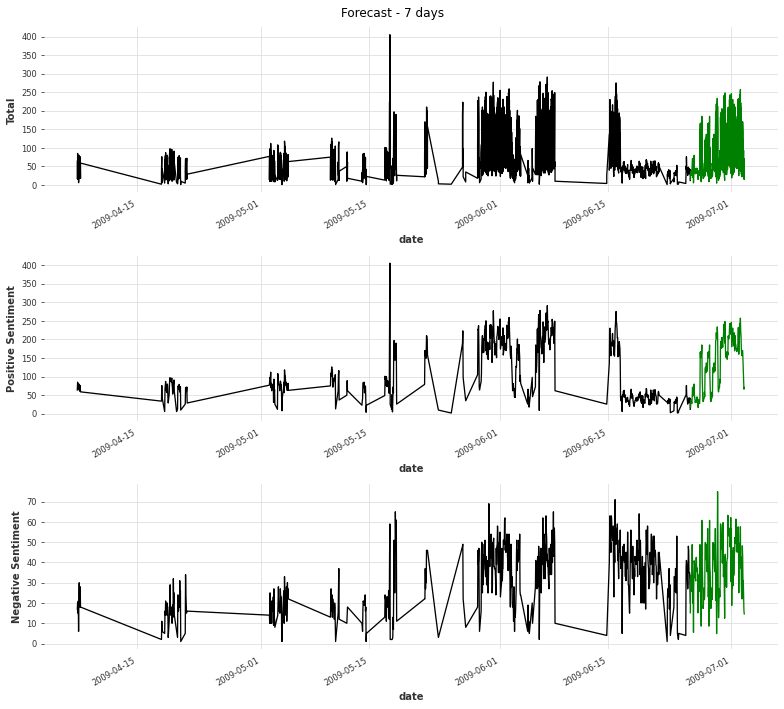

In [88]:
future_7d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 7,
                      model = reg_mod)

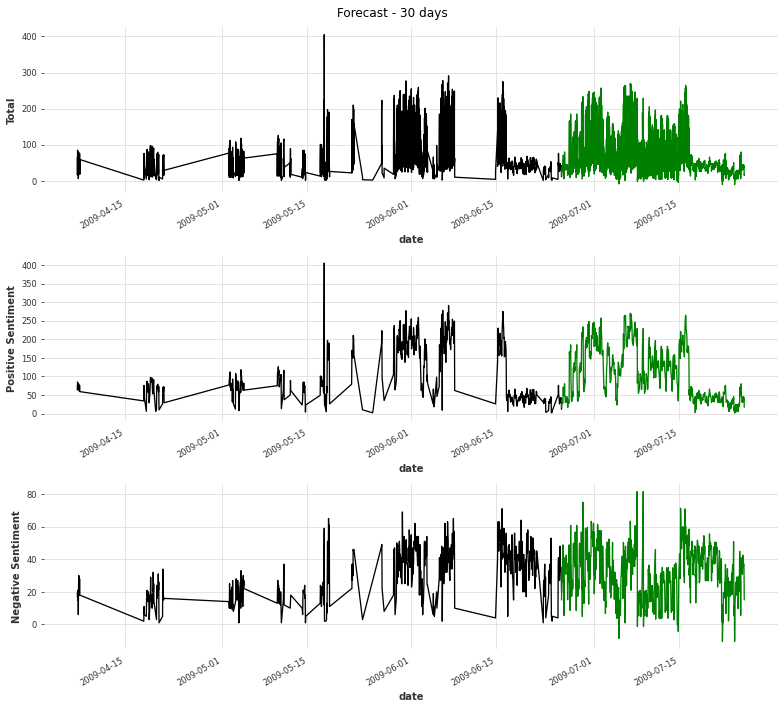

In [89]:
future_30d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 30,
                      model = reg_mod)

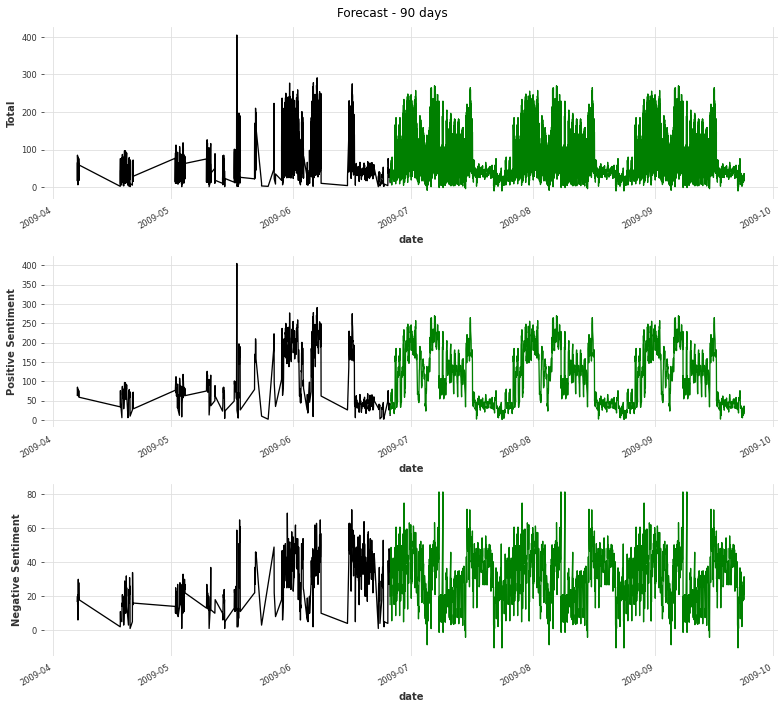

In [90]:
future_90d = df_future(df_trained = tweets_hour_pd, 
                      day_future = 90,
                      model = reg_mod)